# list源码解析

list对象，是容量自适应的数组式容器

## 基本用法

In [4]:
# 新建一个列表，放在[]中
listx = [1,2,3,4,5,6]
listx

[1, 2, 3, 4, 5, 6]

In [5]:
# list函数，把其他类型的转换为list
list1 = list((1,2,3))
list2 = list('ABC')
display(list1)
display(list2)

[1, 2, 3]

['A', 'B', 'C']

In [6]:
# 访问元素
print(list[0])
print(list[-1])
print(list[1])

list[0]
list[-1]
list[1]


In [7]:
# 切片访问（左闭右开）
print(listx[0:2])
print(listx[:-1])
print(listx[0:])
# 步长为2
print(listx[0:5: 2])
print(listx[: :2])
# 倒序
print(listx[:: -1])
print(listx[3::-1])

[1, 2]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6]
[1, 3, 5]
[1, 3, 5]
[6, 5, 4, 3, 2, 1]
[4, 3, 2, 1]


In [8]:
# 迭代访问
for x in listx:
    print(x)

1
2
3
4
5
6


In [9]:
# 查找元素第一次出现的位置下标
listx.index(2)

1

In [10]:
# 向尾部追加元素，列表自动扩容
listx.append(4)
listx

[1, 2, 3, 4, 5, 6, 4]

In [11]:
# 弹出元素，列表自动缩容
listx.pop() #默认尾部
listx.pop(2)#下标为2的元素

3

In [12]:
listx

[1, 2, 4, 5, 6]

In [13]:
# 插入元素，insert使得元素插入位置的原元素向后移动
listx.insert(0,6)
listx.insert(-1,7)#实际上7在倒数第二个位置
listx.insert(3,8)
listx

[6, 1, 2, 8, 4, 5, 7, 6]

In [14]:
# 删除指定位置的元素
del listx[0]
listx

[1, 2, 8, 4, 5, 7, 6]

In [15]:
# 删除指定值的元素
listx.remove(7)
listx

[1, 2, 8, 4, 5, 6]

In [16]:
# 用一个可迭代对象扩展列表——元素逐一追加到尾部
listx.extend([11,8,8,12])
listx

[1, 2, 8, 4, 5, 6, 11, 8, 8, 12]

In [17]:
# 计算元素出现的个数
listx.count(8)

3

In [18]:
# 反转列表
listx.reverse()
listx

[12, 8, 8, 11, 6, 5, 4, 8, 2, 1]

In [19]:
# 清空列表
listx.clear()
listx

[]

## list内部结构

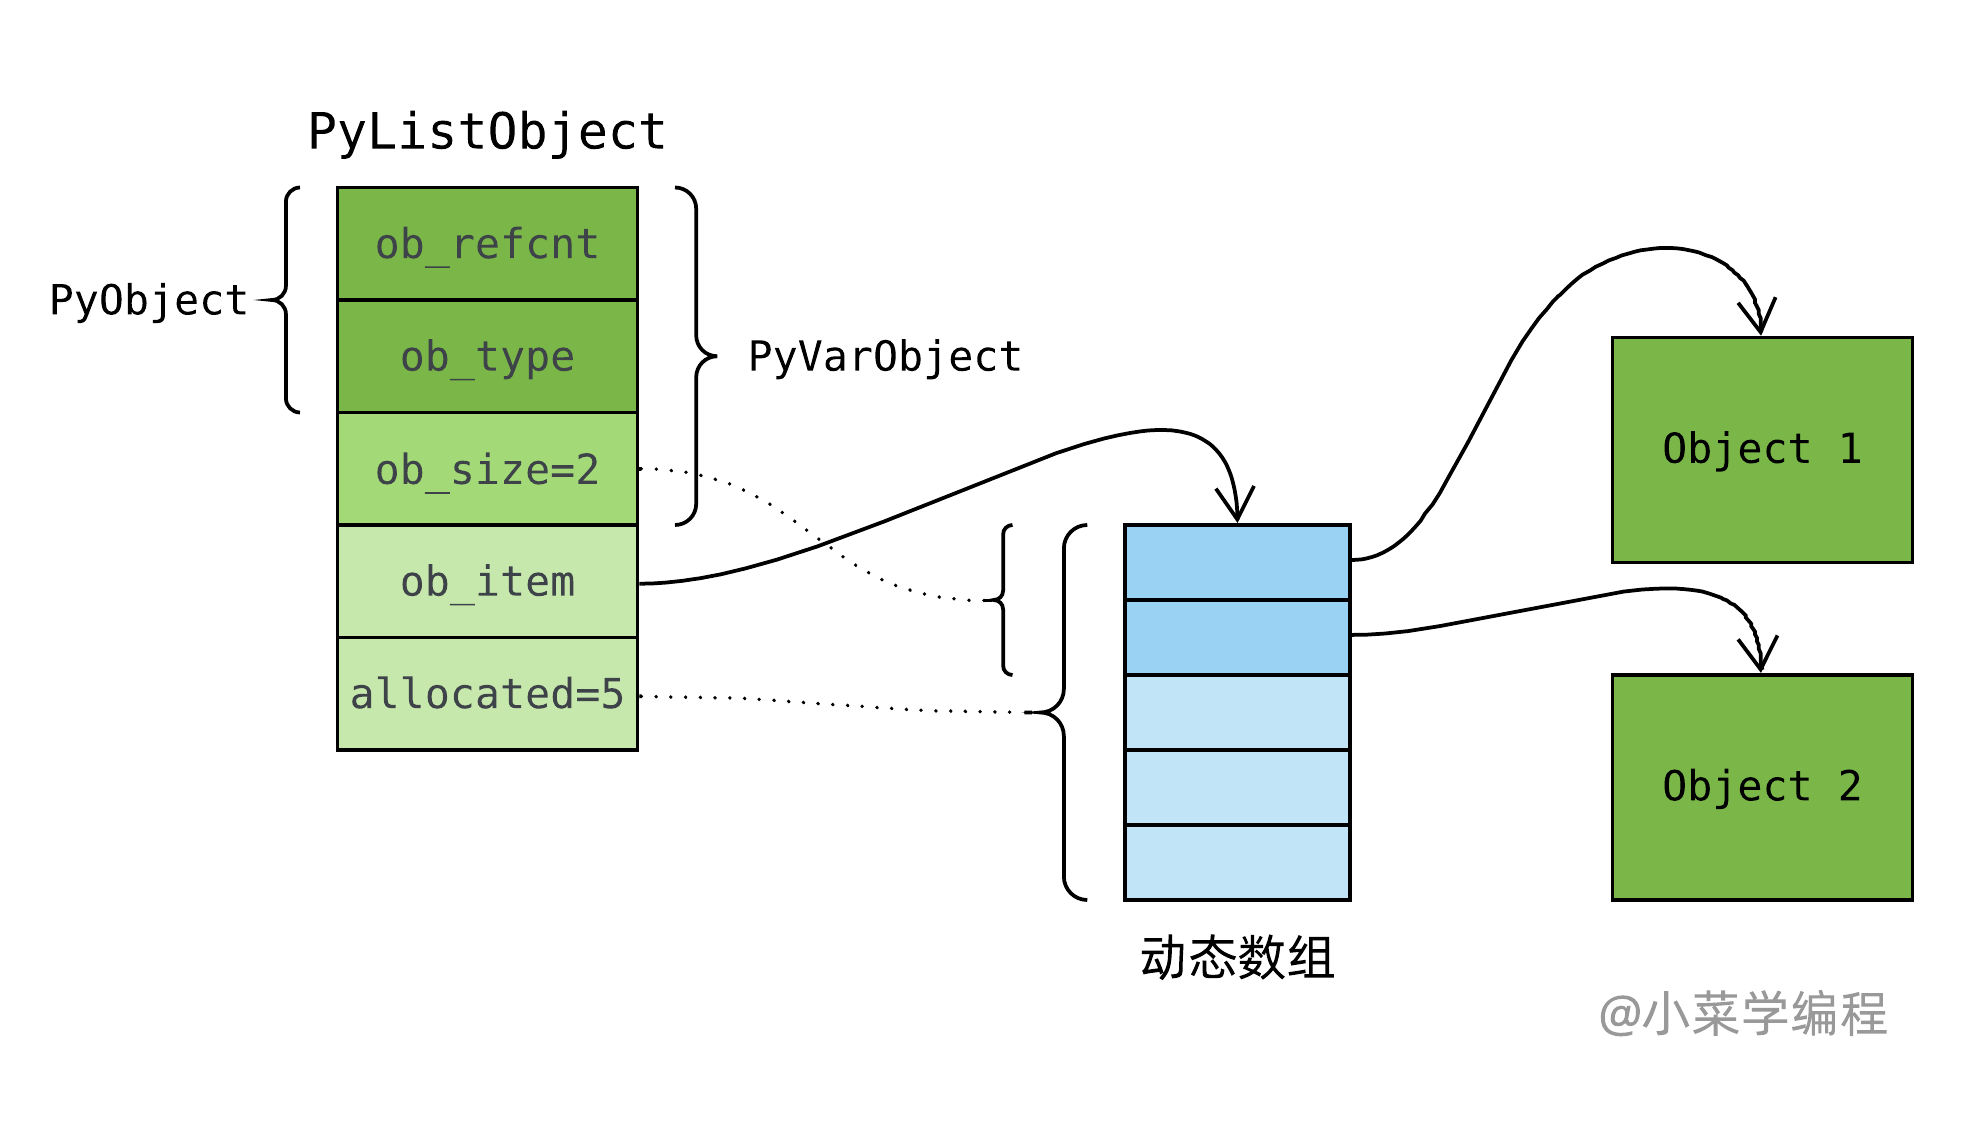

```python
typedef struct {
    PyObject_VAR_HEAD
    /* Vector of pointers to list elements.  list[0] is ob_item[0], etc. */
    PyObject **ob_item;

    /* ob_item contains space for 'allocated' elements.  The number
     * currently in use is ob_size.
     * Invariants:
     *     0 <= ob_size <= allocated
     *     len(list) == ob_size
     *     ob_item == NULL implies ob_size == allocated == 0
     * list.sort() temporarily sets allocated to -1 to detect mutations.
     *
     * Items must normally not be NULL, except during construction when
     * the list is not yet visible outside the function that builds it.
     */
    Py_ssize_t allocated;
} PyListObject;
```

 list 对象是一种变长对象，因此包含变长对象公共头部。除了公共头部,list内部维护了一个动态数组，而数组则依次保存元素对象的指针：

1. ob_item ，指向动态数组的指针，动态数组保存元素对象的指针；
2. allocated ，动态数组长度，即列表容量 ；
3. ob_size ，动态数组当前保存元素个数，即列表长度 ；

## 浅拷贝和深拷贝

浅拷贝：
由于 copy 方法只是对列表对象进行 浅拷贝 ，对新列表可变元素的修改对旧列表可见
列表对象内部数组保存元素对象的指针；`copy`方法复制内部数组时，拷贝的也是元素对象的指针，而不是将元素对象拷贝一遍。因此，新列表对象与旧列表保存的都是同一组对象

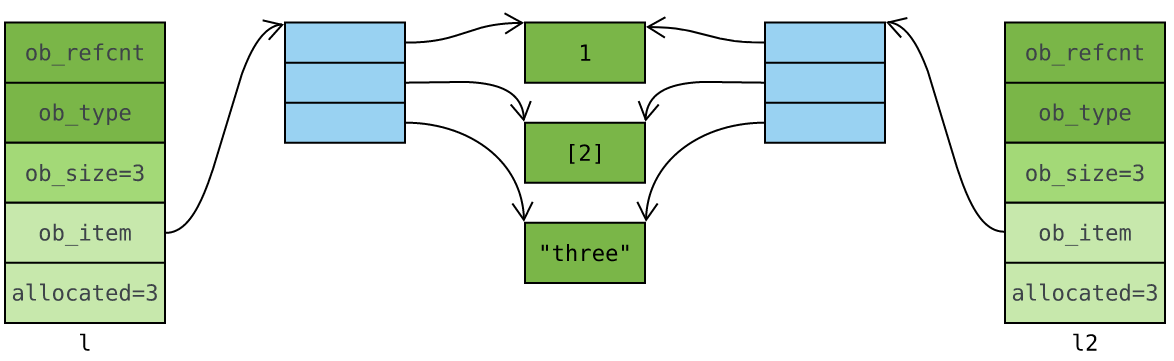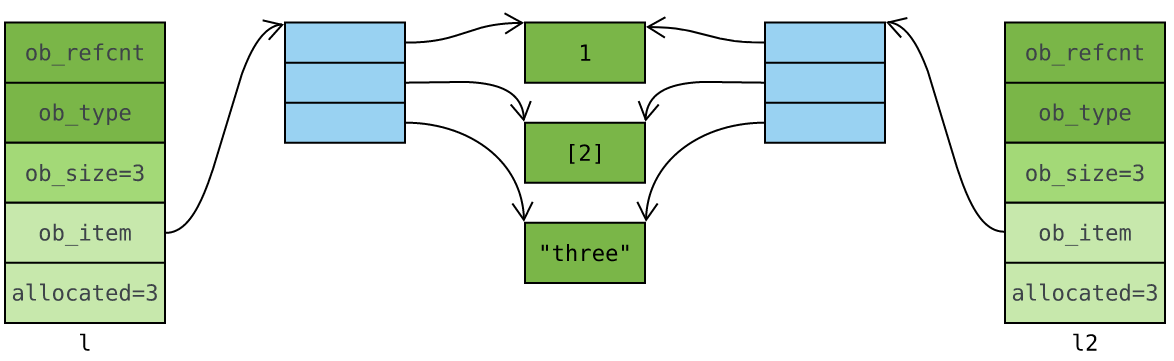

```python
# 创建一个列表
>>> l = [1, [2], 'three']
>>> l
[1, [2], 'three']

# 拷贝形成一个新列表
>>> l2 = l.copy()
>>> l2
[1, [2], 'three']
>>> id(l), id(l2)
(4417331976, 4420505736)
/*此时l2和l的底层动态数组存储的指针是一样的
*/

# 修改新列表不影响旧列表
>>> l2[0] = 'one' # 整型、字符串、浮点数等是不可变对象，'one'是一个新对象，这个新对象的指针存进了l2[0],此时l2[0]和l[0]存储的指针不一样了
>>> l2
['one', [2], 'three']
>>> l
[1, [2], 'three']

# 但是修改新列表中的可变元素，旧列表也跟着变！可变元素不需要新建一个对象就可以改变内容，所以l2[1]和l[1]存储的指针没变
>>> l2[1][0] = 'two'
>>> l2
['one', ['two'], 'three']
>>> l
[1, ['two'], 'three']

```

## 容量调整

扩容/缩容条件：
1. 扩容条件：新长度大于底层数组长度
2. 缩容条件：新长度小于底层数组长度的一半
局部变量：
- newsize：新长度
- items指针：用于保存新数组
- new_allocated：用于保存新数组容量
- num_allocated_bytes：用于保存新数组内存大小，以字节为单位
- allocated：用于保存旧数组容量

```python
static int
list_resize(PyListObject *self, Py_ssize_t newsize)
{
    PyObject **items;
    size_t new_allocated, num_allocated_bytes;
    Py_ssize_t allocated = self->allocated;

    /*检查新长度与底层数组容量的关系。如果新长度不超过数组容量，且不小于数组容量的一半，则无需调整底层数组，直接更新 ob_size 字段。
    */
    if (allocated >= newsize && newsize >= (allocated >> 1)) {
        assert(self->ob_item != NULL || newsize == 0);
        Py_SIZE(self) = newsize;
        return 0;
    }
    # 新容量的长度加上新容量的1/8再加上3或6
    new_allocated = (size_t)newsize + (newsize >> 3) + (newsize < 9 ? 3 : 6);
    # 如果新容量超过允许范围，返回错误；
    if (new_allocated > (size_t)PY_SSIZE_T_MAX / sizeof(PyObject *)) {
        PyErr_NoMemory();
        return -1;
    }
    # 如果新长度为 0 ，将新容量也设置为 0 ，因此空列表底层数组亦为空
    if (newsize == 0)
        new_allocated = 0;
    num_allocated_bytes = new_allocated * sizeof(PyObject *);
    # 调用 PyMem_Realloc 函数重新分配底层数组
    items = (PyObject **)PyMem_Realloc(self->ob_item, num_allocated_bytes);
    if (items == NULL) {
        PyErr_NoMemory();
        return -1;
    }
    # 更新 3 个关键字段，依次设置为 新底层数组、新长度 以及 新容量 
    self->ob_item = items;
    Py_SIZE(self) = newsize;
    self->allocated = new_allocated;
    return 0;
}
```

```python
PyAPI_FUNC(void *) PyMem_Realloc(void *ptr, size_t new_size);
```
_PyMem_Realloc_函数用于对动态内存进行扩容或者缩容，关键步骤如下：
1. 新申请一块尺寸为 new_size 的内存区域；
2. 将数据从旧内存区域 ptr 拷贝到新内存区域；
3. 释放旧内存区域 ptr ；
4. 返回新内存区域；

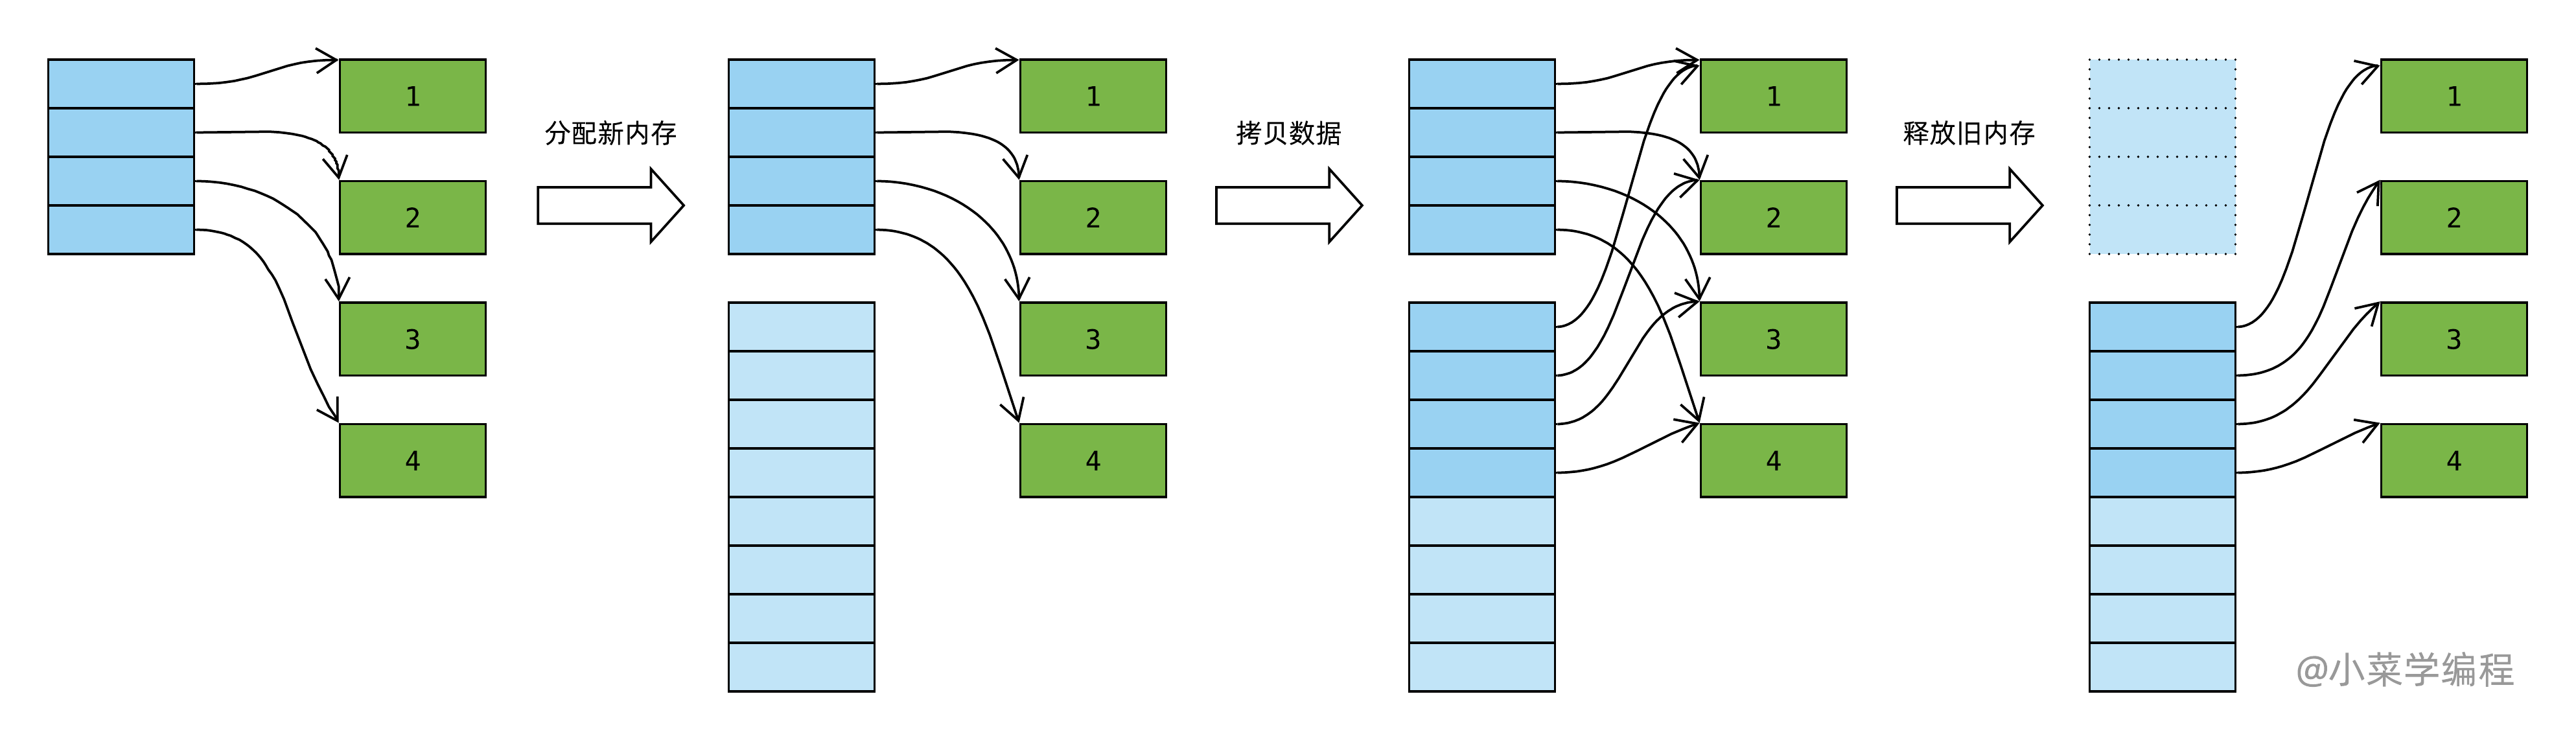